_[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)_

# Thompson Sampling using Conjugate Priors
### Multi-Armed Bandits: Part 5b

![image.gif](Images/unknown_variance_bandit_optimized.gif)

![image.png](Images/power_socket.png)

# Recap <br>

<blockquote>
<i>
Baby Robot has entered a charging room containing 5 different power sockets. Each of these sockets returns a slightly different amount of charge. We want to get Baby Robot charged up in the minimum amount of time, so we need to locate the best socket and then use it until charging is complete.

This is identical to the Multi-Armed Bandit problem except that, instead of looking for a slot machine that gives the best payout, we're looking for a power socket that gives the most charge.
</i>
</blockquote>

---

# Overview

When we looked at the _[theory behind Thompson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8#f535)_  we began with the very simple Bernoulli Bandit problem, in which there were only two possible outcomes. When you selected a power socket you'd either get some charge or no charge. In Bandit terms, when you played a bandit, you'd either win or you'd lose. The challenge was to find the socket with the highest probability of winning.

This simple problem was then extended, to take into account the fact that each socket could actually return a different amount of charge, or each Bandit could payout a different amount of cash.

In both of these cases, rather than use the conventional approach to solving the Bandit Problem, where selections are based on the current mean values of the available choices, we took a Bayesian approach and sampled from a probability model.

These probability models were created using <i>Conjugate Prior</i> distributions. By updating the hyper-parameters of the conjuage prior we were able to create increasingly accurate predictions about the true distribution.

However, although we examined how we could tackle the problem of each socket returning a variable amount of charge, drawn from a normal distribution, we restricted the problem to use a fixed variance. In real world situations this is unlikely to be the case. Each socket is likely to have a different variance. And so, in this short post, we'll extend our examples to show how Thompson Sampling can be used when neither the mean nor the variance are known.

---

# Using Conjugate Priors to Create Probability Models

When selecting an action, from a set of possible actions, Thompson Sampling takes a Bayesian approach. In our socket problem, we maintain a model of the probability distribution of each socket's actual output. Then, when we want to decide which socket to try, we randomly choose a value from each of these models and select the socket with the highest returned value.

Obviously, before we have tried any of the sockets, our initial estimate of the true output could be well off the mark. However, as we start collecting data by using the sockets, we can begin to refine our estimate and gradually build up an increasingly accurate model of the true output.

In Bayesian terms our initial estimate is known as the <i>prior probability</i> and, after seeing some data and refining this estimate, we form the <i>posterior probability</i>. When both the prior and posterior have the same type of probability distribution they are said to be conjugate distributions. Additionally, when this happens, the prior is said to be the <i>conjugate prior</i> of the likelihood distribution (which can be thought of as the actual distribution of the data).

When the likelihood probability distribution has one of the more common distributions then the type of its conjugate prior can be found in the __[table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)__ on Wikipedia. Additionally, for each type of conjugate prior, this table specifies a set of hyper-parameters that can be updated, after seeing some data, to move from the prior to the posterior. In this way the probability model becomes more accurate, letting us make a more informed choice as to the best action to take.

In this article we'll look at how the conjugate prior can be created for a normally distributed likelihood when:

* The variance is known, but the mean is unknown.
* The mean is known, but the variance is unknown.
* Both the mean and variance are unknown.

---

# Setup and Utility Functions

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.core.pylabtools import figsize
norm = stats.norm
gamma = stats.gamma

# matplotlib setup
figsize(11.0, 10)
x = np.linspace(0.0,16.0,200)

In [121]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [123]:
def plot_pdf( trials, mean, variance, label, ymax = 0, set_height=False ):

  y = norm.pdf( x, mean, np.sqrt(variance) )

  p = plt.plot(x, y, lw=2, label = label )
  c = p[0].get_markeredgecolor()    
  plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
  plt.legend()
  plt.autoscale(tight=True)

  plt.vlines(mean, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    
  if ymax == 0: ymax = y[1:].max()*1.1     
    
  if set_height:
    axes = plt.gca()
    axes.set_ylim([0,ymax])   
  
  return ymax


def plot_gamma( trials, alpha, beta, label, ymax = 0, precision = 0 ):

  variance = beta / (alpha + 1)
  
  y = stats.gamma.pdf(x, a=alpha, scale=1/beta)

  p = plt.plot(x, y, lw=2, label = f"var = {alpha/beta**2:.3f}" )
  c = p[0].get_markeredgecolor()  
  
  plt.fill_between(x, y, 0, color=c, alpha=0.2 )
  
  # if supplied, show the true precision
  if precision > 0:
    plt.vlines(x=[precision], ymin=0, ymax=(y[1:].max()*1.1), colors = c, linestyles = "--", lw = 2)
    
  plt.title(f"{trials} Trials - Mean Precision = {1/variance:.2f}")
  plt.legend() 
  plt.autoscale(tight=True)

  axes = plt.gca()
  axes.set_ylim([0,y[1:].max()*1.1]) 
  
figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,18.0,200)


def plot_socket_pdfs(sockets): 
  
  ymax = 0    
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its true values
    y = norm.pdf( x, socket.μ, np.sqrt(socket.v))

    p = plt.plot(x, y, lw=2, label = f"{index}" )
    c = p[0].get_markeredgecolor()    
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])          
  
  plt.legend(title = 'Sockets')
  plt.title('Density Plot of Socket Outputs')
  plt.xlabel('Socket Output (seconds of charge)')
  plt.ylabel('Density')   
  
  
def plot_socket( socket, ymax = 0, title = None ):
  ymax1 = plot_pdf( socket.n, socket.μ, socket.v, "True", ymax )  
  ymax2 = plot_pdf( socket.n, socket.μ_0, socket.v_0, "Estimated", ymax )  
  
  if title is None: title = f"{socket.n} Trials"        
  plt.title(title)
    
  # if no vertical extent is set automatically add space at top
  # - chooses the max from the 2 plots and adds 5%
  if ymax == 0: ymax = max(ymax1,ymax2)*1.05  
  axes = plt.gca()
  axes.set_ylim([0,ymax])    
  

def plot_sockets(sockets, socket_probabilities ):
    
  trials = sum([socket.n for socket in sockets])           
  plt.title(f"{trials} Trials")    
  
  ymax = 0    
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its estimates
    y = norm.pdf( x, socket.μ_0, np.sqrt(socket.v_0) )
    
    p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
    c = p[0].get_markeredgecolor()    
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ_0, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])    

# Known Variance, Unknown Mean

This is the case we looked at already, when we described the theory behind Thompson Sampling. Each of the sockets in our test system would return a charge from a normal distribution with variance equal to one and an unknown mean.

When the likelihood value (i.e. the actual value from the socket) is drawn from a normal distribution, and the variance is known but the mean value is not, then the table of conjugate priors on Wikipedia tells us that the Conjugate Prior is also a normal distribution with parameters mean 'μ₀' and total precision 'τ₀' (remember that the precision 'τ' (tau), is just one over the variance (precision τ = 1/variance). We use the precision version of the equation in preference to the variance version just because it simplifies things a bit.

And the update functions for the hyper-parameters are:

![image.png](Images/ts_tao_formula.png)

![image.png](Images/ts_mu_formula.png)

where:

* 'τ' is the true precision of the actual socket output, which in this case is fixed.
* 'n' is the number of times the socket has been tested.
* 'xᵢ' is the output received at each test 'i' of this socket.
* 'μ₀' is the estimated mean (the mean of the distribution used to model the output).
* 'τ₀' is the total precision (the sum of all individual precisions).

A Python implementation of these update equations is shown below. This updates the hyper-parameters for the conjugate prior of a normal distribution with known variance and unknown mean:

In [6]:
class UnknownMeanKnownVariance:
  
    def __init__(self, μ, v):       
        self.μ = μ   # the true mean 
        self.v = v   # the true variance
        self.τ = 1/v # the true precision
              
        self.n = 0   # the number of times this socket has been tried
        self.x = []  # list of all samples
               
        self.μ_0 = 1 # the posterior (estimated) mean
        
        # the posterior variance
        # - we know this, so set it equal to the true variance
        self.v_0 = v 
        
        # the sum of all individual precisions
        self.τ_0 = 0.0001
        
    def charge(self):
      ''' return a value using the true mean and variance for the socket '''
              
      # take the first (and only) value from the single item list
      value = np.random.normal( self.μ, np.sqrt(self.v), 1)[0]        
      
      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value
        
    def sample(self):  
      ''' return a value from the the prior normal distribution '''               
      return np.random.normal( self.μ_0, np.sqrt(1/self.τ_0) )    

    def update(self,x):
      ''' increase the number of times this socket has been used and improve the estimate of the 
          value (the mean) by combining the new value 'x' with the current mean '''
      
      self.n += 1
      self.x.append(x)  # append the new value to the list of samples
            
      # update the mean of the posterior      
      self.μ_0 = ((self.τ_0 * self.μ_0) + (self.τ * np.array(self.x).sum()))/(self.τ_0 + (self.n*self.τ))     
      
      # increase the sum of all precisions
      self.τ_0 = self.n * self.τ    

In the previous article we used the variable names relating to multi-armed bandits, but have changed things here so that the variables explicitly match up with the equations from Wikipedia (so the reward 'R' is now a data value 'x', and instead of keeping a running estimate of the average reward 'Q' we explicitly store the supplied data at each time step).

One other thing to note is that we previously just used a variance of 1 (since this is the default in the numpy randn function). Now we allow any variance to be used although, since we're considering the situation of a known variance, we just set the variance of the posterior distribution to be the value defined for the underlying distribution of the socket.

Using a single socket, with its underlying reward distribution initialised with a set mean and variance, we repeatedly sample from the true distribution and supply this value to the update function. The hyper-parameters of the conjugate prior are then updated and the posterior distribution moves to become a more accurate representation of the true distribution.

This is shown below for a socket with a true mean of 8 and a variance of 5. Here it can be seen how the estimated mean moves to become a very accurate estimate of the true mean. (The width of the distribution is already correct, since we know the variance.)

In [3]:
''' set the default values to use for the test socket '''
mean = 8
variance = 5

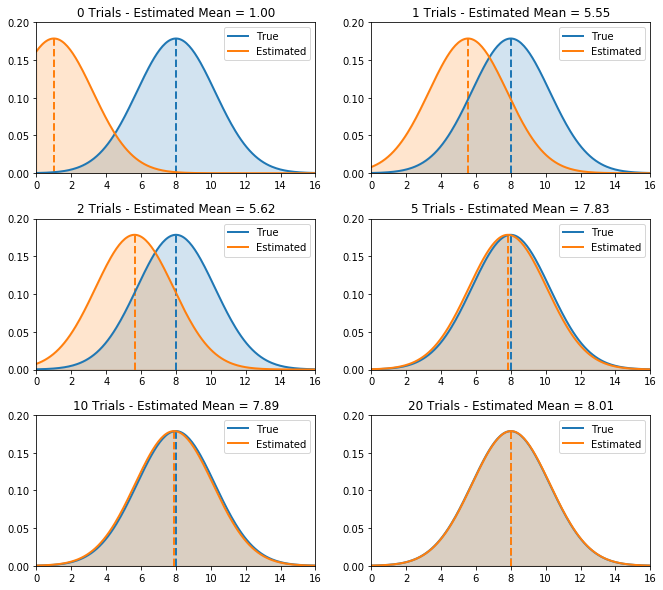

In [21]:
socket = UnknownMeanKnownVariance( mean, variance )

draw_samples = [0, 1, 1, 3, 5, 10]

x = np.linspace(0.0,16.0,200)
figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  for k in range(i):          
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)                   
    
  plot_socket( socket, ymax = 0.2, title = f"{socket.n} Trials - Estimated Mean = {socket.μ_0:.2f}")    
# plt.savefig("Images/unknown_mean_known_variance.png",bbox_inches='tight')

<i>Posterior update for an unknown mean and known variance (true mean = 8 and true variance = 5)</i>

In the plots shown above, the estimated distribution is created using the mean value that has been calculated in the update function, when the posterior's hyper-parameters are updated. However, the variance that is used is the socket's true variance and not the variance of the conjugate prior (the update function actually computes the precision for the conjugate prior, but it's simply a case of taking the reciprocal of this to get to the variance).

It's worth looking at how the variance of the conjugate prior changes as the hyper-parameters are updated and this is shown below:
(<i>note that this was from a different run of the test, so the estimated mean values won't match with those above</i>).

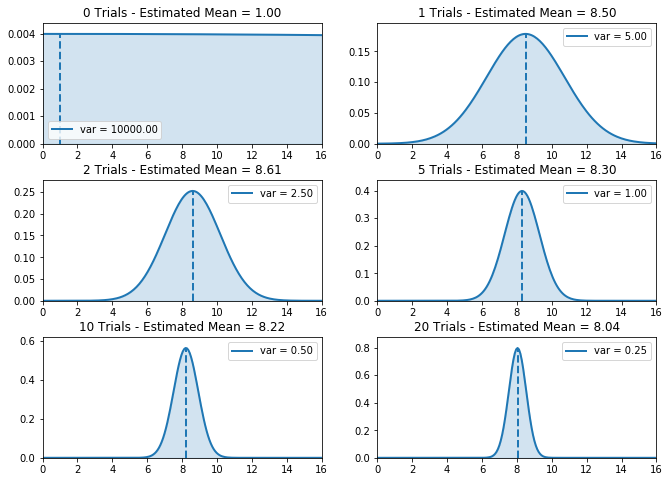

In [26]:
socket = UnknownMeanKnownVariance( mean, variance )

x = np.linspace(0.0,16.0,200)
figsize(11.0, 8)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)   
  plt.subplots_adjust(hspace = 0.3)
  for k in range(i):          
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward) 

  plot_pdf( socket.n, socket.μ_0, 1/socket.τ_0, f"var = {1/socket.τ_0:.2f}",set_height=True)  
  plt.title(f"{socket.n} Trials - Estimated Mean = {socket.μ_0:.2f}")

# plt.savefig("Images/unknown_mean_known_variance_prior.png",bbox_inches='tight')   

As we've already seen, as the number of trials increases, the estimated mean moves closer to the true mean (which in this case has a value of 8). In terms of the socket problem, each time a socket is tried, its estimate of the true mean output for that socket becomes more accurate. 

We could just exploit this knowledge, and choose the socket with the current highest estimate, as done in the greedy algorithm. However, this would then suffer from the same limitation as the greedy algorithm: the lack of exploration. Thompson sampling overcomes this problem, and introduces exploration, by sampling from the prior probability distribution. 

The variance of the distributions shown above, represented by the width of the curve, is a measure of the confidence in each prediction of the mean. As the distribution becomes narrower, so we become more confident in the accuracy of the prediction. Similarly, in the bandit system, as the confidence increases so the level of exploration will decrease.

Initially we want a lot of exploration and so we set the starting variance to produce an almost flat, uniform, distribution. This makes all values equally likely and so all sockets will be tried during the first time steps. 
As actual data starts to be gathered from the socket the hyper-parameters of the conjugate prior are updated and the prior probability distribution will start to narrow. 

The chances of selecting a badly performing socket will reduce since their distribution will shrink towards the left of the graph, while the distribution of sockets that perform well will start to move to the right. Therefore, the probability decreases of a sample value from a bad socket being higher than a sample value from a good socket.

---

# Unknown Variance, Known Mean

So far we haven't seen much that we didn't already cover when we first looked at Thompson Sampling. However, the point of this extra article is to see how we can use Thompson Sampling when we know neither the mean nor the variance of the sockets, so let's take our first step in that direction. In this case we'll use a fixed value for the mean and use an unknown variance. 

Consulting our trusty __[table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)__ on Wikipedia, we see that a normal likelihood distribution, with a known mean, has a conjugate prior of either a gamma or inverse-gamma, depending on whether you want the model parameter to be the precision or the variance. As before, working with the precision is slightly easier, so we'll go with the gamma distribution for our conjugate prior. The update equations for this are shown below.<br><br>


![image.png](Images/gamma_update.png)
<center><i>Update equations for the gamma conjugate prior</i></center><br>



As with the beta distribution, which we used for the _[Bernoulli bandit](https://towardsdatascience.com/thompson-sampling-fc28817eacb8#f535)_, the gamma distribution takes two parameters, 'α' (alpha) and 'β' (beta). In the beta distribution both of these parameters are termed 'shape' parameters since, unsurprisingly, they control the shape of the distribution. Whereas, in the gamma distribution, only 'α' is a shape parameter, with 'β' being defined as a 'rate' parameter which is related to the distribution's variance. From the update equations it's easy to see that 'α' is a count of the number of values sampled and 'β' is a measure of the sample variance.

Additionally, the beta distribution is only defined over the range zero to one (which makes it good for modelling events that have 2 possible outcomes), whereas the gamma distribution is defined over the range of all positive numbers.


<blockquote>
If you're getting bored of always consulting the Wikipedia table to find the conjugate prior, you could instead check out this nice diagram that shows which conjugate prior go with each distribution: <a>href="https://www.johndcook.com/blog/conjugate_prior_diagram/"</a>
</blockquote>

As we did for the normal distribution with fixed variance and unknown mean, we can easily take these equations and form a Python update function, as shown below:

In [28]:
class KnownMeanUnknownVariance:
  
    def __init__(self, μ, v):       
        self.μ = μ   # the true mean 
        self.v = v   # the true variance
                      
        self.n = 0   # the number of times this socket has been tried
        self.x = []  # list of all samples
               
        # the posterior (estimated) mean
        # - we know this, so set it equal to the true mean
        self.μ_0 = μ                     
        
        # the posterior (estimated) variance
        self.v_0 = 1 
                
        self.α = 1   # gamma shape parameter         
        self.β = 1   # gamma rate parameter 
        
    def charge(self):
      ''' return a value using the true mean and variance for the socket '''
              
      # take the first (and only) value from the single item list
      value = np.random.normal( self.μ, np.sqrt(self.v), 1)[0]        
      
      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value
        
    def sample(self):  
      ''' sample from our estimated normal
        - this uses the estimated mean and the true variance '''               

      # using gamma function directly gives estimate of precision
      # - inverse gamma would give variance
      # np's gamma fn takes 'scale' as its second parameter which is 1/β      
      # convert back from precision to variance
      return 1/np.random.gamma(self.α, 1/self.β)

    def update(self,x):
      ''' increase the number of times this socket has been used and improve the estimate of the 
          variance by updating the gamma distribution's hyper-parameters using the new value 'x' '''
      
      self.n += 1
      self.x.append(x)  # append the new value to the list of samples             

      self.α = self.n/2
      self.β = ((np.array(self.x) - self.μ)**2).sum()/2          
        
      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)   

Again we've directly implemented the update equations in code and used exactly the same naming convention. We're also still appending each new sample value to an array of all values seen over the course of a run and then using this in the calculation of the variance for the 'β' update. As mentioned previously, in practice this would be impractical due to memory constraints and the fact that the time taken to calculate the variance will increase with every new sample value.

One other point to note is that rather than updating the previous value of the hyper-parameters, we're explicitly setting them to new values. For example, for 'α' we're doing "self.α = self.n/2" as opposed to "self.α = self.α + self.n/2" which at first glance would more closely match with the update equation.

The update function forms the posterior distribution from the prior distribution combined with 'n' sample data points. So, in this case, we consider 'n' to be the number of data points seen from the start of the run. For each new data point, we recalculate the posterior distribution over the entire set of sampled data that we've seen so far. So the prior distribution is taken to be defined by the initial values of 'α' and 'β' (which we've effectively set to be zero).

When updating the hyper-parameters it's also possible to consider the prior to be formed not by the initial values of 'α' and 'β', but instead by their values that were calculated at the previous update. So, at each time step, the prior is given by the previous posterior. In this case 'n' doesn't represent the total number of sample values that have been seen but instead is the total number of sample values seen since the last update, which in our case will always be 1. This is the approach that we'll take when we implement the update function when both the mean and variance are unknown.

As we did before, we now define a single socket,  with a true mean of 8 and a variance of 5, and repeatedly sample from it and update its hyper-parameters. In this case the mean of the model distribution is set to be the true value of 8 and the variance is refined using the update function, to move its distribution ever closer to the true distribution of the socket output, as shown below.

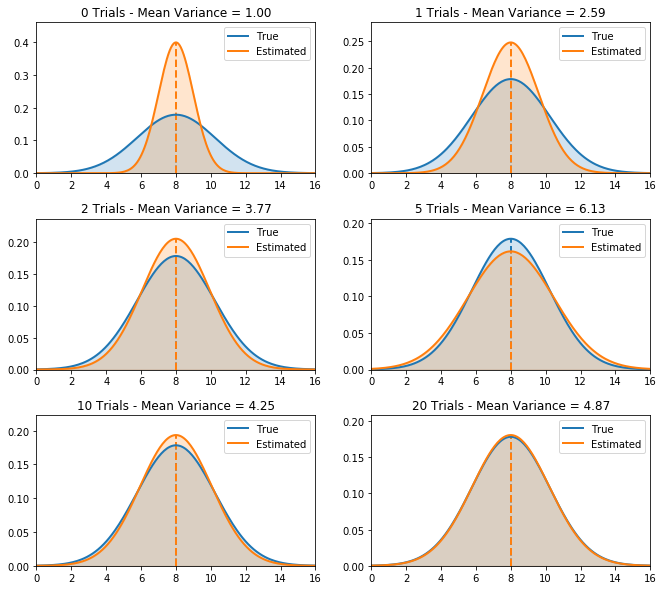

In [47]:
socket = KnownMeanUnknownVariance( mean, variance )
draw_samples = [0, 1, 1, 3, 5, 10]

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)            
          
  plot_socket( socket, title = f"{socket.n} Trials - Mean Variance = {socket.v_0:.2f}")
    
# plt.savefig("Images/known_mean_unknown_variance.png",bbox_inches='tight') 

In this experiment the socket output is given by a normal distribution with a known mean but unknown variance. So the variance is considered to be a random value and the conjugate prior distribution represents the probability of the true variance's value. So the conjugate prior can be thought of as being the probability of a probability.

This can be understood more easily by examining how the distribution of the posterior changes as the hyper-parameters are updated, as shown below:

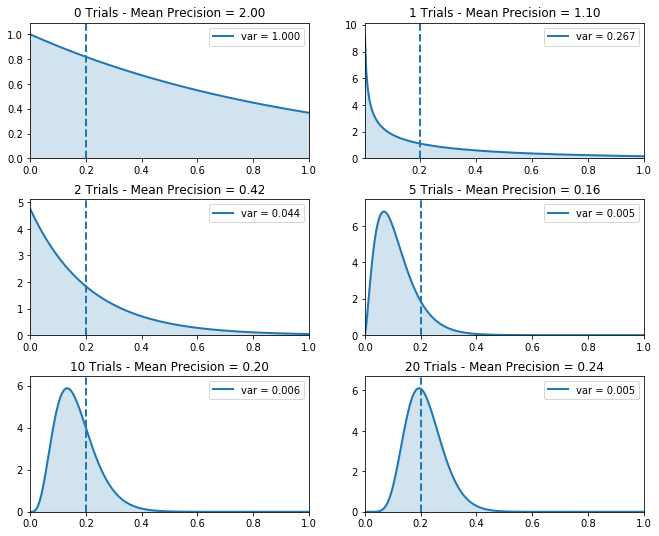

In [74]:
socket = KnownMeanUnknownVariance( mean, variance )
x = np.linspace(0.0,1.0,200)

figsize(11.0, 9)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)   
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)    
      
  plot_gamma( socket.n, socket.α, socket.β, f"{1/socket.v_0}", precision = 1/socket.v )  
  
# plt.savefig("Images/known_mean_unknown_variance_prior.png",bbox_inches='tight') 

<center><i>The posterior distribution, shown over increasing trials, for a gamma conjugate prior</i></center>

---

The gamma distribution is used as the conjugate prior when the model parameter is the precision, so the graphs above represent the probability distribution that the precision has a certain value. Since the socket's true variance is 5, the true precision is 1/5 = 0.2.

* At zero trials the hyper-parameters are set such that the gamma distribution covers all values between zero and one. Essentially it currently has no idea what the true precisions of the socket could be and so all values are likely.


* As the socket is sampled at each trial and the hyper-parameters are updated, so the shape of the gamma distribution starts to narrow and move towards the true precision.


* By 20 trials the posterior distribution has centred itself on the true precision and the variance of the posterior distribution (as opposed to the variance of the true socket distribution) has decreased significantly, indicating a high level of confidence in the predicted value.

---

# Unknown Variance, Unknown Mean

We've now seen how we can use a normal distribution as the conjugate prior when the likelihood also has a normal distribution with a known variance and we can use a gamma distribution when we know the mean. So, unsurprisingly, when we know neither the mean nor the variance we can use a __[normal-gamma](https://en.wikipedia.org/wiki/Normal-gamma_distribution)__ (this is actually for an unknown mean and precision, if the model parameter is the variance then the normal-inverse-gamma would be used).

In this case there are four hyper-parameters for the conjugate prior and these have the following update functions: <br><br>


![image.png](Images/normal_gamma.png)


where:
* 'μ₀' is the estimated mean. So this is the mean of our prior distribution that is used to model the output.
* 'ν' (nu) is the number of observations used to form the estimated, prior, mean.
* 'α' is the gamma's shape parameter and is a count of the total number of samples.
* 'β' is gamma rate parameter and is a measure of the variance.
* 'n' is the number of times the socket has been tested (the number of observed samples) since the creation of the prior.
*'xᵢ' is the output received at each test 'i' of this socket after the creation of the prior.
* x̄ is the mean of the sample data


Given the large number of parameters these update functions can appear pretty daunting, but really there are only 2 things going on:

* a prior distribution is formed from 'ν' samples and that has a mean of 'μ₀'

* the posterior distribution is formed by using the 'n' samples that come after the creation of the prior (so each xᵢ) and these have a mean value of x̄.


When we were finding the unknown variance we considered 'n' to be the total number of samples taken right from the start of the experiment and the prior was considered to be our very initial guess. But, as we've already described, it's also possible to consider the prior to be the posterior that was calculated at the previous time step. This means that, since we're only seeing a single new sample value in the update function, that 'n' becomes 1. Additionally, since there's only a single sample value then x̄, the mean of the sample data, is equal to x and so the complete sum in the beta update function becomes zero.

With these simplifications it becomes easy to write the matching Python update function:


In [125]:
class UnknownMeanUnknownVariance:
  
    def __init__(self, μ, v):       
      self.μ = μ   # the true mean 
      self.v = v   # the true variance
                      
      self.n = 0   # the number of times this socket has been tried
      self.x = []  # list of all samples
               
      self.α = 1   # gamma shape parameter  
      self.β = 10  # gamma rate parameter  
      
      self.μ_0 = 1 # the prior (estimated) mean
      self.v_0 = self.β / (self.α + 1) # the prior (estimated) variance             
                    
    def update(self,x):        
      ''' increase the number of times this socket has been used and improve the estimate of the 
          mean and variance by combining the single new value 'x' with the current estimate '''
      n = 1
      v = self.n
      
      self.α = self.α + n/2     
      self.β = self.β + ((n*v/(v + n)) * (((x - self.μ_0)**2)/2))
      
      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)      
            
      self.x.append(x)  # append the new value to the list of samples 
      self.n += 1
      self.μ_0 = np.array(self.x).mean()          
        
    def charge(self):
      ''' return a value using the true mean and variance for the socket '''              
      value = np.random.normal( self.μ, np.sqrt(self.v) )
      
      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value      
    
    def sample(self):  
      ''' sample from our estimated normal '''                   
      
      precision = np.random.gamma(self.α, 1/self.β)
      if precision == 0 or self.n == 0: precision = 0.001
      
      estimated_variance = 1/precision
      return np.random.normal( self.μ_0, np.sqrt(estimated_variance))

Note that here, the local variable 'n' represents the number of sample values seen since the last time step, so is just set to a value of 1, whereas 'self.n' represents the total number of sample values seen since the start of the run, which is equivalent to 'ν' in the update equations.

With this update function, the distribution of the conjugate prior over an increasing number of trials is shown below.

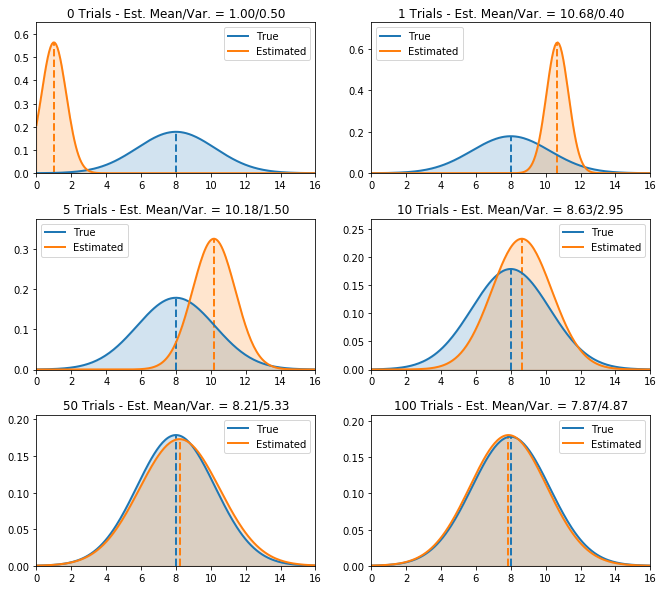

In [115]:
socket = UnknownMeanUnknownVariance( mean, variance )

draw_samples = [0, 1, 4, 5, 40, 50]
x = np.linspace(0.0,16.0,200)

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    reward = socket.charge()
    socket.update(reward)          

  title = f"{socket.n} Trials - Est. Mean/Var. = {socket.μ_0:0.2f}/{socket.v_0:.2f}"  
  plot_socket( socket, title = title )
    
# plt.savefig("Images/unknown_mean_unknown_variance.png",bbox_inches='tight') 

<center><i>Posterior update for an unknown mean and unknown variance (true mean = 8 and true variance = 5)</i></center><br><br>

In the posterior update graphs shown above you can see how, with increasing trials, our estimate moves to become an ever closer match of the true output distribution. In this case, after 100 trials, it has become an almost exact match of the socket's actual output.

Now that we know how to form a good model we can use this as the distribution to sample from during Thompson Sampling. So we can finally return to our original objective, of solving the bandit problem when the underlying distribution of the sockets is a normal distribution with unknown mean and variance.

---

# Bandit Problem with Unknown Mean and Unknown Variance

In the graph, shown below, the five sockets of the charging room have been modified. Now, not only do the distributions of the power output each have a different mean, but they also each have a different variance.

In [116]:
socket_true_values = [6, 10, 8, 12, 11]
socket_variance = [2,5,3,1,6]

print(f"True Values = {socket_true_values}")
print(f"Variances = {socket_variance}")

True Values = [6, 10, 8, 12, 11]
Variances = [2, 5, 3, 1, 6]


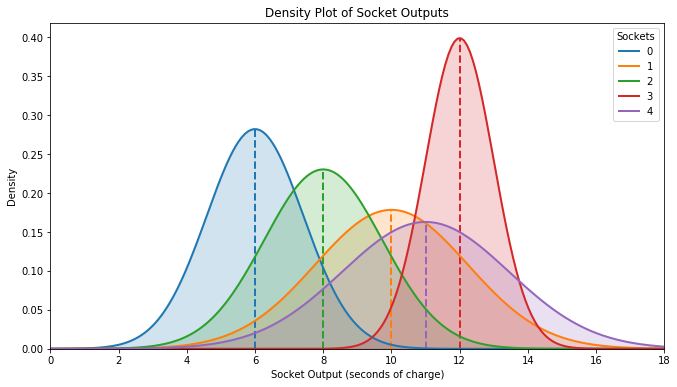

In [119]:
# create the sockets
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]

figsize(11.0, 6)
plot_socket_pdfs( sockets )
plt.savefig("Images/unknown_mean_unknown_variance_pdf.png",bbox_inches='tight') 

<center><i>Power output distributions of the sockets with unique mean and variance.</i></center><br><br>

The sockets have true mean values of [6, 10, 8, 12, 11] and true variances of [2,5,3,1,6]. 

With these distributions it can be seen that socket number 3 (where socket numbering begins at zero) is the socket with the highest mean output and so this is the socket that we'd like to locate. However, sockets 1 and 4 have a high variance, such that their distributions extend beyond that of socket 3. So, on occasion, they may produce an output that is greater than any that could be produced by socket 3. 

We've already produced the update function that we need to progressively improve our model for each socket. The one other main component we require for Thompson Sampling is a "sample" function that will randomly choose values from this model, and this is shown in the "UnknownMeanUnknownVariance" class from above.

The sample function has 2 parts:

* It first samples from gamma distribution using the alpha and beta hyper-parameters that get updated each time the socket is sampled. 
The gamma distribution gives us an estimate of the socket's precision, so we use the reciprocal of this to get the estimated variance. 

* The estimated variance is then used with our estimated mean for the socket, to give the complete estimate of the socket's output. We then return a value sampled from this.

Note that we also check if the precision is zero or this is the very first sample from the socket. If it is, then we return a very small precision. As well as avoiding any divide by zero errors, this causes the resultant normal distribution to have a high variance. This has a similar effect as when we used a high initialisation value for the optimistic-greedy algorithm or a flat, uniform, distribution with the beta conjugate prior and results in all of the sockets being tried during the initial trials.
The results from a single run of Thompson Sampling, using a normal-gamma conjugate prior, are shown below:

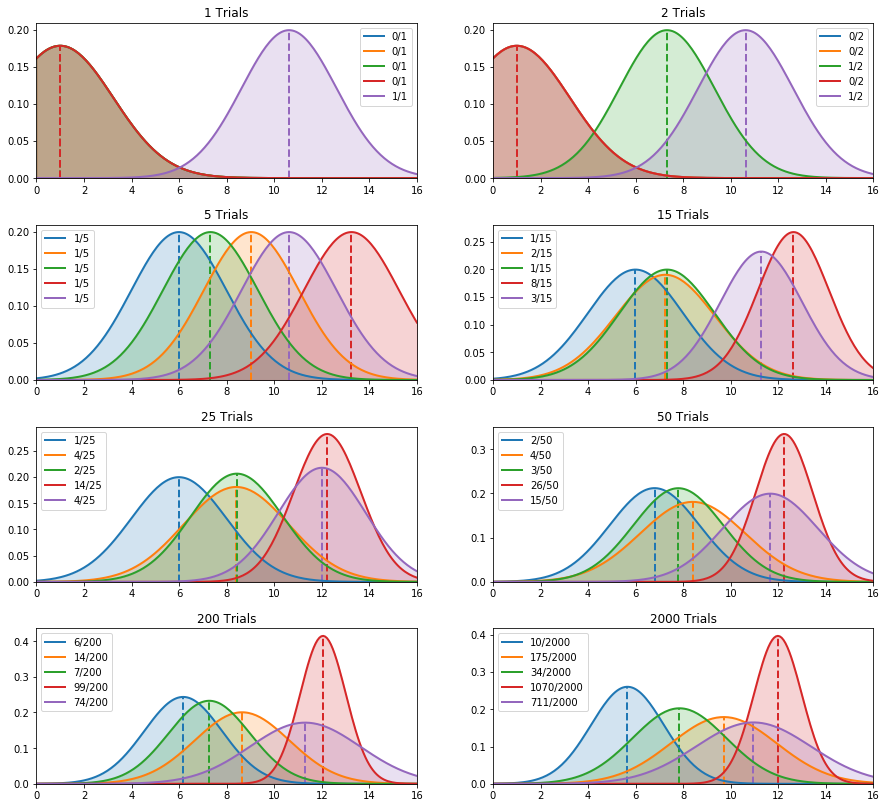

In [130]:
%matplotlib inline
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 1800]
x = np.linspace(0.0,16.0,200)

figsize(15.0, 14)
for j,i in enumerate(draw_samples):
  plt.subplot(4, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
    socket_samples = [socket.sample() for socket in sockets]
    socket_index = random_argmax(socket_samples)     

    # charge from the chosen socket and update its mean reward value
    reward = sockets[socket_index].charge()
    sockets[socket_index].update(reward)          
  
  plot_sockets(sockets, socket_true_values)

# plt.savefig("Images/thompson_unknown_mean_unknown_variance.png",bbox_inches='tight')

<center><i>Thompson Sampling on sockets with an underlying normal distribution of unknown mean and variance.</i></center><br>

The main points of note from the graphs shown above are:


* Due to setting a high variance for the initial estimate of each socket's distribution, each socket is tried once during the first 5 trials (note that due to the random sampling from the distribution, this isn't guaranteed but will make it likely that each socket is tested during the early stages of the run).


* As the test progresses the estimated distributions of the sockets change to more accurately resemble the true, underlying, distributions of the sockets.


* The number of trials allocated to each socket is proportional to the true mean value for the sockets. As a socket's mean value increases so the number of times that socket is tested also increases.


* After only 50 trials the shape and positioning of the estimated distributions is a very close match to the true distributions. By the end of test they're an almost exact match. 


In the animation, shown below, it's clear to see how the shape of the posterior estimates changes as new data arrives and the hyper-parameters are updated. 

(<i>note this is from a different run to the graphs given above, so the trials for each socket will be different.</i>)

In [133]:
%%capture
# stop the initial figure from being shown

from matplotlib.animation import FuncAnimation
from IPython.core.pylabtools import figsize
from IPython.display import HTML
import scipy.stats as stats
norm = stats.norm

x = np.linspace(0.0,18.0,200) 

# setup the axis of the figure
figsize(11.0, 6)
fig = plt.figure()
ax = plt.axes(xlim=(2, 16), ylim=(0, 0.5))

plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')   

# define a text list for the legend - standard legends dont work well with animation
texts = [ax.text(0.88, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(len(sockets)+2)]
texts[1].set_text('sockets:')   

lines = []
for index in range(len(sockets)):
  lobj = ax.plot([],[],lw=2)[0]      
  lines.append(lobj)  

    
# animation initialisation 
def init():
  for line in lines:
      line.set_data([],[])      
  return lines


# animate function called at each step
def animate(i):
    
  # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
  socket_samples = [socket.sample() for socket in sockets]
  socket_index = random_argmax(socket_samples)     

  # charge from the chosen socket and update its mean reward value
  reward = sockets[socket_index].charge()
  sockets[socket_index].update(reward)    
  
  texts[0].set_text(f'trials: {i}')  
  
  ax.collections.clear()
  for index, socket in enumerate(sockets):                 
    
    y = norm.pdf( x, socket.μ_0, np.sqrt(socket.v_0) )     
    
    line = lines[index]
    line.set_data(x, y)
    texts[index+2].set_text(f'     {index}: {socket.n}')  
                    
    c = line.get_markeredgecolor()    
    ax.fill_between(x, y, 0, color=c, alpha=0.2 )           
        
    # add the coloured lines to the legend
    ax.hlines(y=0.431-index*0.0245, xmin=14.3, xmax=14.6, linewidth=3, color=c)    

  return lines

In [139]:
%matplotlib notebook
''' Run the test and show the results - this can take a while before the image is shown '''
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)
HTML(anim.to_jshtml()) 

<center><i>The posterior estimate updates of the 5 sockets, shown over 100 trials.</i></center>

# Summary

In the previous article we'd already covered the main theory behind Thompson Sampling. This article was intended to build on this, taking the  theory and showing how it can be applied in practice to update the conjugate prior.

Specifically we've looked at Thompson Sampling when the sample data has a normal distribution with an unknown mean and variance. By building accurate models of the underlying distributions it becomes possible to sample from these, to choose the best options when this information is initially unknown.

Obviously, to use conjugate priors for Thompson Sampling relies upon a knowledge of the underlying distribution of the data and of this distribution having conjugate priors. In practice this may not be the case and therefore other techniques, such as Monte Carlo based methods (which we'll look at in a future article), will be required to solve the problem.

# References

For a more in-depth look at the topics that have been covered try checking out the following resources:

__Bayesian Statistics:__<br>
[1] "Introduction to Applied Bayesian Statistics and Estimation for Social Scientists", Lynch, Scott M. (2007).

__Bayesian Bandits:__ <br>
[2] "Multi-Armed Bandits", Cameron Davidson-Pilon
https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits<br>
[3] "Multi-Armed Bandits and Conjugate Models - Bayesian Reinforcement Learning (Part 1)", George Ho
https://eigenfoo.xyz/bayesian-bandits/#fn:2

__Conjugate Priors:__<br>
[4] "Conjugate Bayesian analysis of the Gaussian distribution",
Kevin P. Murphy
https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf<br>
[5] "The Conjugate Prior for the Normal Distribution", Michael I. Jordan, 2010
https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf